In [ ]:
# WEC Podium Prediction Model
# Coded by Kavin Vasudevan, Sidharth Bansal, Murtaza Shiyaji

In [ ]:
#Kaggle Link: https://www.kaggle.com/datasets/tristenterracciano/fia-wec-lap-data-20122022
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import plot_tree

# First we load the dataset from the kaggle API

In [ ]:
path = kagglehub.dataset_download("tristenterracciano/fia-wec-lap-data-20122022")
print("Path to dataset files:", path)
files = os.listdir(path)
print(files)

100%|██████████| 44.0M/44.0M [00:01<00:00, 37.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tristenterracciano/fia-wec-lap-data-20122022/versions/13
['2012-2022_FIA_WEC_FULL_LAP_DATA.csv']


In [ ]:
dataframes = {}
for filename in os.listdir(path):
  if filename.endswith(('.csv', '.txt')):
    file_path = os.path.join(path, filename)
    try:
        df = pd.read_csv(file_path)
    except pd.errors.ParserError:
        try:
            df = pd.read_table(file_path)
        except pd.errors.ParserError:
            print(f"Skipping file {filename}: Could not parse as CSV or TXT")
            continue
    dataframes[filename] = df


<ipython-input-4-59743cf58bae>:6: DtypeWarning: Columns (26,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


# Helper functions for data preprocessing

In [ ]:
def add_finishing_positions(group):
    team_summary = group.groupby('team_no', as_index=False).agg({
        'laps_completed': 'max',
        'last_position': 'min'
    })
    team_summary = team_summary.sort_values(by=['laps_completed', 'last_position'], ascending=[False, True])
    team_summary['ending_rank'] = range(1, len(team_summary) + 1)
    group = group.merge(team_summary[['team_no', 'ending_rank']], on='team_no', how='left')

    return group

### Creating the 'start_position' and 'podium' columns

In [ ]:
start_finish = df[["season", "circuit", "class", "lap_number", "team_no", "class_position"]]

grouped = start_finish.groupby(['season', 'circuit', 'class', 'team_no'])

starting_positions = grouped.apply(lambda x: x.loc[x['lap_number'].idxmin(), 'class_position']).reset_index(name='starting_position')
with_starting = start_finish.merge(starting_positions, on=['season', 'circuit', 'class', 'team_no'])


laps_completed = grouped['lap_number'].max().reset_index(name='laps_completed')
with_laps_completed = with_starting.merge(laps_completed, on=['season', 'circuit', 'class', 'team_no'])

last_positions = grouped.apply(
    lambda x: x.loc[x['lap_number'].idxmax(), ['class_position', 'lap_number']]
).reset_index()
last_positions.columns = ['season', 'circuit', 'class', 'team_no', 'last_position', 'last_lap']
with_laps_completed = with_laps_completed.merge(last_positions, on=['season', 'circuit', 'class', 'team_no'])
with_start_finish = with_laps_completed.groupby(['season', 'circuit', 'class'], group_keys=False).apply(add_finishing_positions)
with_start_finish['podium'] = with_start_finish['ending_rank'].apply(lambda x: 1 if 1 <= x <= 3 else 0)
with_start_finish
df = with_start_finish.merge(
    df,
    on=['season', 'circuit', 'class', 'team_no', 'lap_number', 'class_position'],
    how='left'
)

<ipython-input-6-097a4f94cfe6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  starting_positions = grouped.apply(lambda x: x.loc[x['lap_number'].idxmin(), 'class_position']).reset_index(name='starting_position')
<ipython-input-6-097a4f94cfe6>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_positions = grouped.apply(
<ipython-input-6-097a4f94cfe6>:17: DeprecationWarning: DataFrameGroupBy.apply opera

### Columns that need to be dropped:
number, driver_number, lap_improvement, crossing_finish_line_in_pit, s1_improvement, s2_improvement, s3_improvement, elapsed, hour, s1_large, s2_large, s3_large, driver_name, pit_time, group, team, round, vehicle, flag_at_fl, lap_time, lap_time_ms, lap_time_s, engine, driver_stint_no, driver_stint, team_stint, elapsed_ms, position, interval_ms, interval, gap, class_interval, class_gap, elapsed_s


In [ ]:
columns = [
    "number", "driver_number", "lap_improvement", "crossing_finish_line_in_pit",
    "s1_improvement", "s2_improvement", "s3_improvement", "elapsed", "hour",
    "s1_large", "s2_large", "s3_large", "driver_name", "pit_time", "group",
    "team", "round", "vehicle", "flag_at_fl", "lap_time", "lap_time_ms", "lap_time_s",
    "engine", "driver_stint_no", "driver_stint", "team_stint", "elapsed_ms",
    "position", "interval_ms", "interval", "gap", "class_interval",
    "class_gap", "elapsed_s",
    "class_position", "laps_completed", "last_position", "last_lap", "ending_rank", "Unnamed: 0"
]

df.drop(columns, inplace=True, axis=1)

# Fill in NA values

In [ ]:
for col in ['s1', 's2', 's3', 'top_speed']:
  df[col] = df.groupby(['season', 'circuit', 'class'])[col].transform(lambda group: group.fillna(group.mean()))

# Merging each driver's laps into 1 single row

In [ ]:
merged_df = df.groupby(['season', 'circuit', 'class', 'team_no', 'starting_position', 'podium', 'manufacturer'], as_index=False).agg(
    {
    's1': 'mean',
    's2': 'mean',
    's3': 'mean',
    'kph': 'mean',
    'top_speed': 'mean',
    'team_stint_no': 'max'
    })

# Normalizing start position and drop 'team_no'

In [ ]:
merged_df['normalized_starting_position'] = (
    merged_df.groupby(['season', 'circuit', 'class'])['starting_position']
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)

merged_df.drop('starting_position', axis=1, inplace=True)

# Add speed_efficiency

In [ ]:
merged_df["speed_efficiency"] = merged_df["kph"] / merged_df["top_speed"]

# Split into training and testing data

In [ ]:
train_data = merged_df[merged_df['season'] != 2022]
test_data = merged_df[merged_df['season'] == 2022]

#Drop 'season' and 'team_no'

In [ ]:
train_data.drop(['season', 'team_no'], axis=1, inplace=True)
test_data.drop(['season', 'team_no'], axis=1, inplace=True)

<ipython-input-13-d753e8e5f7f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['season', 'team_no'], axis=1, inplace=True)
<ipython-input-13-d753e8e5f7f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['season', 'team_no'], axis=1, inplace=True)


# Model Creation

In [ ]:
features = ['circuit', 'class', 'manufacturer', 's1', 's2', 's3', 'kph', 'top_speed', 'team_stint_no', 'normalized_starting_position', 'speed_efficiency']
target = 'podium'

le = LabelEncoder()
for col in ['circuit', 'class', 'manufacturer']:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])

scaler = StandardScaler()
numerical_features = ['s1', 's2', 's3', 'kph', 'top_speed', 'team_stint_no', 'speed_efficiency']
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])
test_data[numerical_features] = scaler.transform(test_data[numerical_features])

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

model = RandomForestClassifier(random_state=42, n_estimators = 150, max_depth=30, bootstrap=True, criterion="log_loss")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


<ipython-input-14-af6086b59f4c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[col] = le.fit_transform(train_data[col])
<ipython-input-14-af6086b59f4c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[col] = le.transform(test_data[col])
<ipython-input-14-af6086b59f4c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        98
           1       0.70      0.39      0.50        36

    accuracy                           0.79       134
   macro avg       0.75      0.66      0.68       134
weighted avg       0.78      0.79      0.77       134

0.7910447761194029


# Visualize our model and results

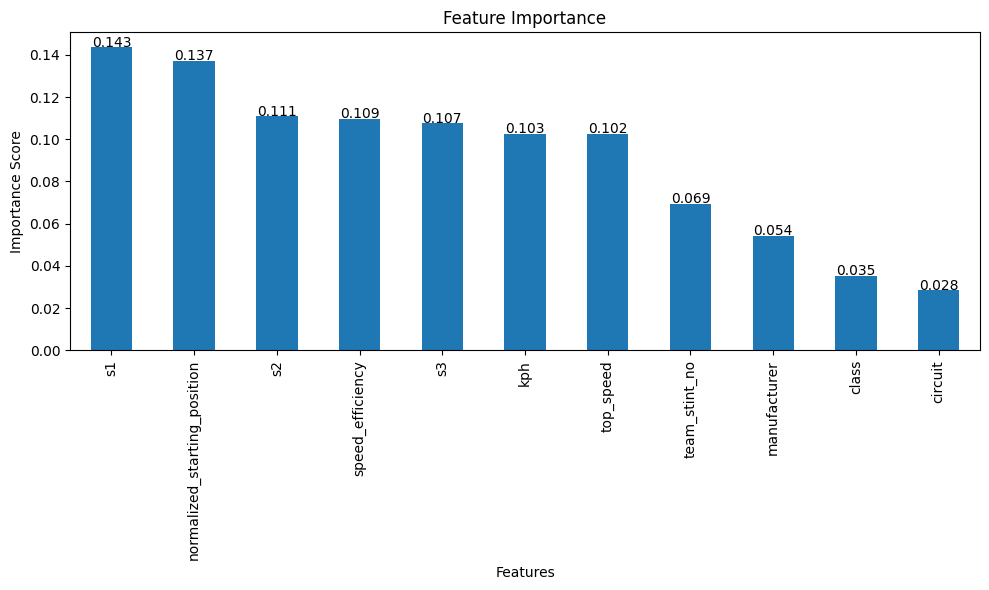

In [ ]:
importances = model.feature_importances_
indices = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
indices.plot(kind='bar')

for i, value in enumerate(indices):
    plt.text(i, value - 0.001, f"{value:.3f}", ha='center', va='bottom', fontsize=10)

plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

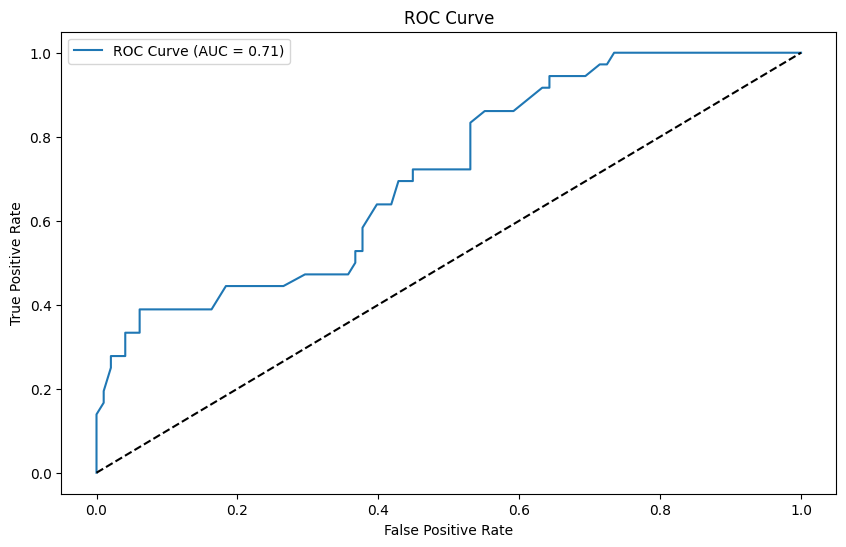

In [ ]:
y_pred = model.predict(X_test)
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


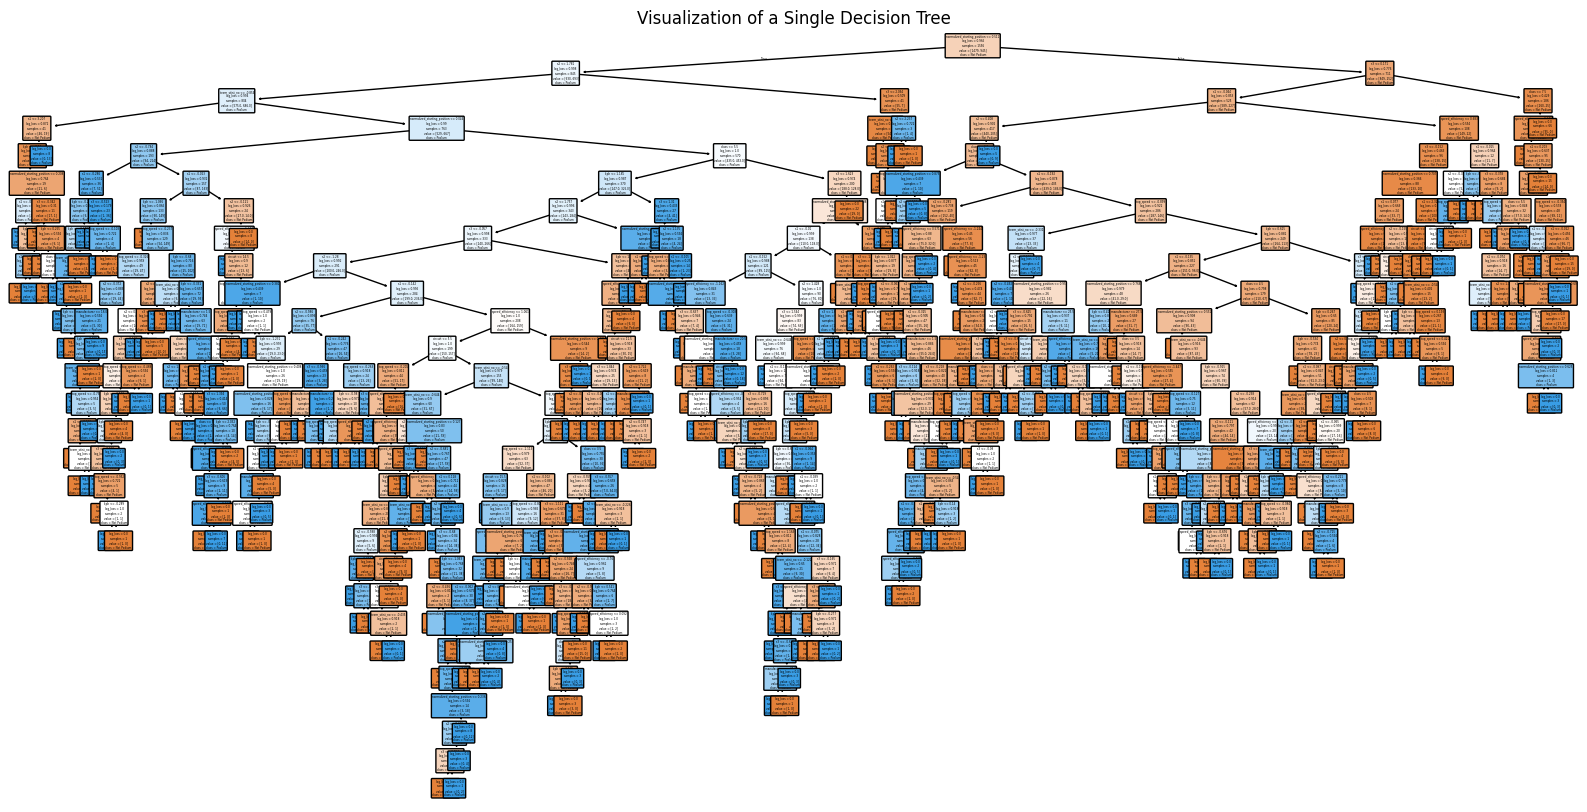

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0],
          feature_names=features,
          class_names=['Not Podium', 'Podium'],
          filled=True,
          rounded=True,
          fontsize=2)
plt.title("Visualization of a Single Decision Tree")
plt.show()